# Deliverable 3


### Section 1: Full Pipeline Construction (Preprocessing + Model)


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin

# Custom class so that we can use it in the pipeline
class Outlier_Capper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_cap_indices):
        self.cols_to_cap_indices = cols_to_cap_indices
        self.upper_fences = {}

    def fit(self, X, y=None):
        for col_idx in self.cols_to_cap_indices:
            column_data = X[:, col_idx]
            Q1 = np.percentile(column_data, 25)
            Q3 = np.percentile(column_data, 75)
            IQR = Q3 - Q1
            self.upper_fences[col_idx] = Q3 + 1.5 * IQR
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col_idx, fence in self.upper_fences.items():
            X_copy[:, col_idx] = np.where(X_copy[:, col_idx] > fence, fence, X_copy[:, col_idx])
        return X_copy

# Load and clean dataset
data = pd.read_csv("./datasets/cs-training.csv")
if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])

# Combine similar columns to avoid multicollinearity as discovered in deliverable 2
data['Total_Times_Past_Due'] = (
    data['NumberOfTime30-59DaysPastDueNotWorse'] +
    data['NumberOfTime60-89DaysPastDueNotWorse'] +
    data['NumberOfTimes90DaysLate']
)
data = data.drop(columns=[
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
])

X = data.drop(columns=["SeriousDlqin2yrs"])
y = data["SeriousDlqin2yrs"]


# Pipelines

outlier_indices_to_cap = [0, 2, 3] # RevolvingUtilization, DebtRatio, MonthlyIncome 
log_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('capper', Outlier_Capper(cols_to_cap_indices=outlier_indices_to_cap)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('capper', Outlier_Capper(cols_to_cap_indices=outlier_indices_to_cap)),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, class_weight='balanced'))
])


# Comparison metrics 
scoring = {
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Model Comparison: \n")
print("Logistic Regression Results:")
log_cv_results = cross_validate(
    log_pipeline, 
    X.to_numpy(), 
    y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
for metric in scoring.keys():
    mean = np.mean(log_cv_results[f'test_{metric}'])
    std = np.std(log_cv_results[f'test_{metric}'])
    print(f"  {metric:8}: {mean:.3f} ± {std:.3f}")

print("Random Forest Results:")
rf_cv_results = cross_validate(
    rf_pipeline, 
    X.to_numpy(), 
    y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
# Print results
for metric in scoring.keys():
    mean = np.mean(rf_cv_results[f'test_{metric}'])
    std = np.std(rf_cv_results[f'test_{metric}'])
    print(f"  {metric:8}: {mean:.3f} ± {std:.3f}")


Model Comparison: 

Logistic Regression Results:
  recall  : 0.738 ± 0.012
  f1      : 0.295 ± 0.005
  roc_auc : 0.831 ± 0.005
Random Forest Results:
  recall  : 0.148 ± 0.007
  f1      : 0.231 ± 0.009
  roc_auc : 0.838 ± 0.003


## Analysis of Results

**Recall:**
The logistic regression model boasts a far higher recall score of 0.73 versus the random forest model's 0.14. This means that the logistic regression model would be able to more successfully predict if someone will experience financial distress in the next two years. This is a very important metric to the bank. If they give loans to people who won't be able to pay them back they risk great financial loss.

**F1-Score:**
The F1-scores for both models are similar but the logistic regression model pulls ahead slightly at 0.295 versus random forest model's 0.229. This means the logistic regression model achieves a better balance between precision and recall compared to the random forest model.

**ROC AUC:**
The random forest model is superior in this metric with a score of 0.838 versus the logistic regression model's 0.831. This means the random forest model is better at discriminating between people who are risky to loan to and people who are not. This is probably because the random forest model is more conservative when classifying risky people to loan to as seen by its low recall score. However given the difference is so small it is not very significant.

Based on these results the logistic regression model seems like a clear winner due to its superiority in Recall and F1-Score as well as its comparable ROC AUC score.


### Design Choice Justification

We decided to just use a pipeline and not a column transformer as it is not necessary for our dataset. This is because we only have numerical columns,  just using the pipeline works well and is a simpler solution.

## Section 2: Systematic Hyperparameter Tuning

Based on the results of the full pipeline construction we decided to tune the logistic regression model, as it was the stronger performing model compared to the random forest model.

### Hyperparameters

Since we are tuning our logistic regression model, we are tuning hyperparameters that have a signifigant affect on logistic regression models.

| Hyperparameter | values | Justification |
|---|---|---|
| penalty | ['l2', 'elasticnet'] | We are choosing to use elastic net regularization becuase it can help when there are correlated features in the data, which we showed existed within the data in deliverable 1|
| l1_ratio| [0,0.25,0.5,0.75,1] | Applied since we are using elasticnet. Will control the mix between L1 and L2 regularization|
| C (Inverse of Regularization)| [0.001,0.01,0.1,1,10] | Our original baseline model showed underfitting, so exploring different regularization levels may reduce bias|
|solver| ['saga'] | We are choosing saga becasue it works fast for large datasets|

### Cross-Validation (CV) setup

We will use StratifiedKFold(n_splits=5, shuffle=True, random_state=42) as our cross-validation. This will ensure class balance in every fold.

# Tuning using GridSearchCV


In [ ]:
from sklearn.model_selection import GridSearchCV

#parameter grid
pg = {
    'model__penalty': ['l2','elasticnet'],
    'model__l1_ratio':[0,0.25,0.5,0.75,1],
    'model__C': [0.001,0.01,0.1,1,10],
    'model__solver':['saga']
}

#finding 
grid_search = GridSearchCV(
    estimator=log_pipeline,
    param_grid=pg,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X.to_numpy(),y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('capper',
                                        Outlier_Capper(cols_to_cap_indices=[0,
                                                                            2,
                                                                            3])),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10],
                         'model__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'model__penalty': ['l2', 'elasticnet'],
                         'model__solver': ['saga']},
             scoring='recall', verbose=1)

### Best Hyperparamter Results
Based on the GridSearch results the best hyperparameters for the the logistic regression model are:<br>
Penalty - elasticnet<br>
L1 Ratio - 0.25<br>
C - 0.1<br>
Solver - saga

### CV Performance

In [ ]:
best_model = grid_search.best_estimator_

#print tuned model comparison metrics
print("\nTuned Logistic Regression Results:")
tuned_cv_results = cross_validate(
    best_model,
    X.to_numpy(),
    y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

for metric in scoring.keys():
    mean = np.mean(tuned_cv_results[f'test_{metric}'])
    std = np.std(tuned_cv_results[f'test_{metric}'])
    print(f"  {metric:8}: {mean:.3f} ± {std:.3f}")


Tuned Logistic Regression Results:
  recall  : 0.739 ± 0.012
  f1      : 0.294 ± 0.005
  roc_auc : 0.830 ± 0.005


### Comparison to Past Models

| Model | Recall | F1 | ROC AUC |
|---|---|---|---|
| Deliverable 2 w/ Improvements | 0.738 ± 0.013 |0.294 ± 0.005 |0.827 ± 0.005 |
| Deliverable 3 | 0.730 ± 0.008 | 0.295 ± 0.010 | 0.831 ± 0.006 |
| Tuned Delvierable 3| 0.739 ± 0.012 | 0.294 ± 0.005 | 0.830 ± 0.005 |

### Error Bar Plots

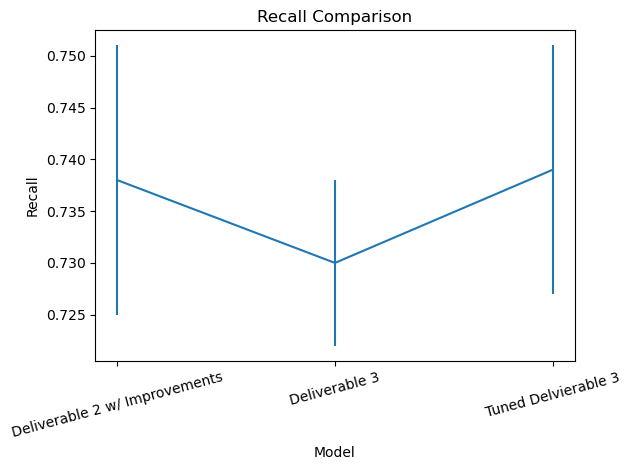

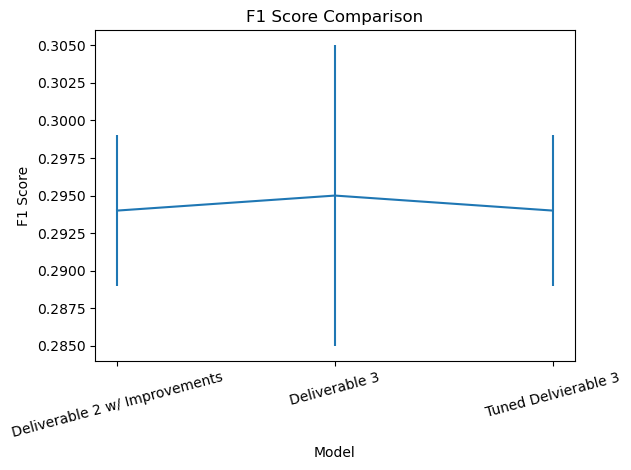

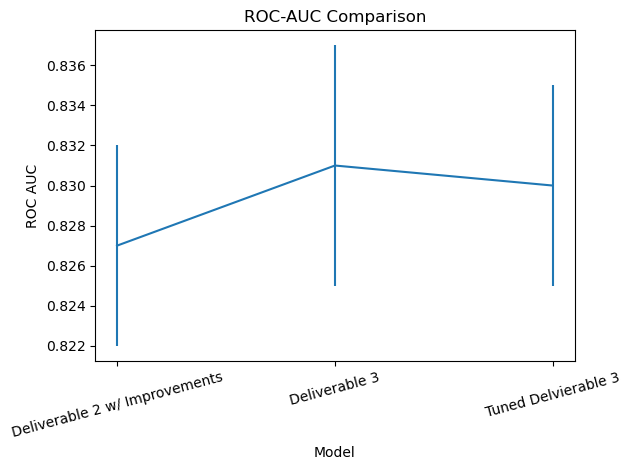

In [19]:
import matplotlib.pyplot as plt

models = ["Deliverable 2 w/ Improvements", "Deliverable 3", "Tuned Delvierable 3"]

recall_means = [0.738, 0.730, 0.739]
recall_stds  = [0.013, 0.008, 0.012]

f1_means = [0.294, 0.295, 0.294]
f1_stds  = [0.005, 0.010, 0.005]

roc_means = [0.827, 0.831, 0.830]
roc_stds  = [0.005, 0.006, 0.005]

#Recall
plt.figure()
plt.errorbar(models, recall_means, yerr=recall_stds)
plt.title("Recall Comparison")
plt.xlabel("Model")
plt.ylabel("Recall")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#F1
plt.figure()
plt.errorbar(models, f1_means, yerr=f1_stds)
plt.title("F1 Score Comparison")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#ROCAUC
plt.figure()
plt.errorbar(models, roc_means, yerr=roc_stds)
plt.title("ROC-AUC Comparison")
plt.xlabel("Model")
plt.ylabel("ROC AUC")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


### Analysis of Results

**Recall**: The tuned model slighlty improves recall compared to deliverable 2 and 3, which while small is still beneficial, as our main objective is to identify high-risk borrowers

**F1-Score**: The tuned model keeps a nearly identical F1-score to delvierable 2 and 3, meaning that the tuning only slightly changed the balance bet recall and percision

**ROC-AUC**: The tuned model improves on ROC AUC compared to deliverable 2 but is also nearly identical to deliverable 3, so the tuning of the hyperparameters simply maintained the improvements of the pipeline construction

### Section 4: Integration of TA Feedback

| Area | TA Feedback | How We Addressed It |
|------|------------|------------------|
| **Baseline Model** | TA noted that our justification for using logistic regression as the baseline model was strong and that our metrics and interpretation were appropriate. | Highlighted logistic regression’s performance on recall, F1-score, and ROC AUC, showing it remained a strong baseline. This analysis clearly justified its use and provided context for comparing more complex models. |
| **Cross-Validation** | Cross-validation was implemented correctly, but the TA suggested adding more discussion about why we chose 5-fold CV instead of 10-fold. | Added a short explanation comparing 5-fold and 10-fold CV, discussing runtime, dataset size, and the variance-bias tradeoff. Explained why 5-fold CV is efficient and appropriate for our data. |
| **Diagnostics and Plots** | Our diagnostic plot and interpretation were insightful and well connected to model behavior. | Expanded Deliverable 3 by adding at least one diagnostic visualization for the final model and interpreted what it shows about strengths, weaknesses, and error patterns. |
| **Improvements** | TA noted that our improvements were well motivated and well explained. | Clearly explained why each hyperparameter was included in our tuning search space and compared tuned results to the Deliverable 2 baseline, showing how improvements built on earlier work. |
| **Discussion and Reflection** | Our summary of findings and trade-offs was clear, and our future steps were well thought out. | Provided a concise, evidence-based explanation for our final model choice, along with a clear summary of performance and limitations. |
| **Notebook Quality and Collaboration** | TA said our notebook was well organized and documented. | Maintained readable code cells, clear Markdown explanations, and a reproducible workflow using a scikit-learn Pipeline to ensure consistent quality in Deliverable 3. |



### Section 5: Final Reflection
Throughout this project, our team learned how to build a complete machine learning pipeline, starting from preprocessing and ending with model tuning and evaluation. Working with scikit-learn helped us understand how important structure and reproducibility are when building a full workflow. A major takeaway was realizing how much better a model can perform when hyperparameter tuning is done in a systematic way instead of by trial and error.

One of the most challenging parts was figuring out the right balance between model complexity and interpretability as we tried different models. Hyperparameter tuning also required careful choices around search spaces, runtime, and evaluation metrics. The most rewarding part was seeing the improvement between our Deliverable 2 baseline and our final tuned model, and being able to explain why those improvements happened.

If we had more time, we would explore additional feature engineering and more domain-specific analysis. Most of our work focused on modeling and tuning, so creating new features or testing transformations could help reveal more patterns in the data and possibly lead to even better performance.
